In [1]:
import pandas as pd
import numpy as np
import re
import keyword
from difflib import get_close_matches
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import Levenshtein
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
import time
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

# Step1: load and clean data

### GOVERNMENT DATA

In [2]:
raw_data = pd.read_csv('https://www.abc.ca.gov/datport/ABC_Data_Export_CSV.zip')
raw_data.head()

,License Type,File Number,License or Application,Type Status,Type Original Issue Dates,Expiration Dates,Fee Codes,Duplicate Counts,Master Indicator,Term in # of Months,...,Premise State,Premise Zip,DBA Name,Mail Street Address 1,Mail Street Address 2,Mail City,Mail State,Mail Zip,Premise County,Premise Census Tract #
0,20,100196,LIC,SUREND,21-JAN-1981,30-JUN-2017,P40,NaN,Y,12,...,CA,92201,NaN,NaN,NaN,NaN,NaN,NaN,RIVERSIDE,455.02
1,20,100275,LIC,ACTIVE,18-AUG-1981,31-MAY-2018,P40,NaN,Y,12,...,CA,95822,MILLERS AM PM,NaN,NaN,NaN,NaN,NaN,SACRAMENTO,38.00
2,41,100297,LIC,ACTIVE,09-JUN-1981,31-DEC-2017,P0,NaN,Y,12,...,CA,95448,ROUND TABLE PIZZA,575 W COLLEGE AVE,STE 201,SANTA ROSA,CA,95401,SONOMA,1539.01
3,41,100298,LIC,ACTIVE,05-OCT-1981,31-DEC-2017,P0,NaN,Y,12,...,CA,95453,ROUND TABLE PIZZA,575 W COLLEGE AVE,STE 201,SANTA ROSA,CA,95401,LAKE,4.00
4,9,100306,LIC,ACTIVE,19-MAY-1981,30-JUN-2017,P0,1.0,N,12,...,CA,93514,GILLESPIE DISTRIBUTING COMPANY INC,NaN,NaN,NaN,NaN,NaN,INYO,4.00


In [3]:
#Because the gov_data also contains licenses from other states, so subsetting only CA data.
gov_data = raw_data.loc[raw_data['Premise State'] == 'CA', :]

#Change Zipcode to only 5 digits.
gov_data['Premise Zip'] = gov_data.loc[:,'Premise Zip'].str.slice(0,5)
gov_data.head()

C:\Users\qguo\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,License Type,File Number,License or Application,Type Status,Type Original Issue Dates,Expiration Dates,Fee Codes,Duplicate Counts,Master Indicator,Term in # of Months,...,Premise State,Premise Zip,DBA Name,Mail Street Address 1,Mail Street Address 2,Mail City,Mail State,Mail Zip,Premise County,Premise Census Tract #
0,20,100196,LIC,SUREND,21-JAN-1981,30-JUN-2017,P40,NaN,Y,12,...,CA,92201,NaN,NaN,NaN,NaN,NaN,NaN,RIVERSIDE,455.02
1,20,100275,LIC,ACTIVE,18-AUG-1981,31-MAY-2018,P40,NaN,Y,12,...,CA,95822,MILLERS AM PM,NaN,NaN,NaN,NaN,NaN,SACRAMENTO,38.00
2,41,100297,LIC,ACTIVE,09-JUN-1981,31-DEC-2017,P0,NaN,Y,12,...,CA,95448,ROUND TABLE PIZZA,575 W COLLEGE AVE,STE 201,SANTA ROSA,CA,95401,SONOMA,1539.01
3,41,100298,LIC,ACTIVE,05-OCT-1981,31-DEC-2017,P0,NaN,Y,12,...,CA,95453,ROUND TABLE PIZZA,575 W COLLEGE AVE,STE 201,SANTA ROSA,CA,95401,LAKE,4.00
4,9,100306,LIC,ACTIVE,19-MAY-1981,30-JUN-2017,P0,1.0,N,12,...,CA,93514,GILLESPIE DISTRIBUTING COMPANY INC,NaN,NaN,NaN,NaN,NaN,INYO,4.00


In [4]:
gov_data.columns

Index(['License Type', 'File Number', 'License or Application', 'Type Status',
       'Type Original Issue Dates', 'Expiration Dates', 'Fee Codes',
       'Duplicate Counts', 'Master Indicator', 'Term in # of Months',
       'Geo Code', 'District / Office Code', 'Primary Name',
       'Premise Street Address 1', 'Premise Street Address 2', 'Premise City',
       'Premise State', 'Premise Zip', 'DBA Name', 'Mail Street Address 1',
       'Mail Street Address 2', 'Mail City', 'Mail State', 'Mail Zip',
       'Premise County', 'Premise Census Tract #'],
      dtype='object')

In [5]:
gov_data.describe()

,License Type,File Number,Duplicate Counts,Term in # of Months,Geo Code,District / Office Code,Premise Census Tract #
count,113663.000000,113663.000000,14654.000000,113663.0,113663.000000,113663.000000,112800.000000
mean,34.729296,461110.286171,1.414358,12.0,2970.206021,15.851931,1825.359968
std,18.029828,123293.466636,7.792846,0.0,1346.948592,9.380925,2306.620328
min,1.000000,4.000000,0.000000,12.0,100.000000,2.000000,0.370000
25%,20.000000,410327.000000,1.000000,12.0,1933.000000,7.000000,85.110000
50%,41.000000,506361.000000,1.000000,12.0,3029.000000,13.000000,525.160000
75%,47.000000,551095.500000,1.000000,12.0,3800.000000,24.000000,3108.000000
max,86.000000,583015.000000,583.000000,12.0,5802.000000,75.000000,9832.000000


In [6]:
#Number of licenses
len(gov_data['File Number'])

113663

In [7]:
#Checking number of missing Address 1
gov_data['Premise Street Address 1'].isnull().sum()

0

In [8]:
#Checking number of missing Address 2
gov_data['Premise Street Address 2'].isnull().sum()

#replace NaN with empty for missing Address 2
gov_data['Premise Street Address 2'] = gov_data['Premise Street Address 2'].replace(np.nan, '', regex=True)

C:\Users\qguo\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [9]:
#Type of License status
gov_data['Type Status'].unique()

array(['SUREND', 'ACTIVE', 'SUSPEN', 'REVPEN', 'PEND', 'R64B', 'SLMSHD'], dtype=object)

In [10]:
#Checking number of stores which are NOT active
len(gov_data.loc[gov_data['Type Status']!='ACTIVE'])

print('There are', round(len(gov_data.loc[gov_data['Type Status']!='ACTIVE'])/len(gov_data['File Number'])*100, 1), '% of NOT active licenses')

There are 7.8 % of NOT active licenses


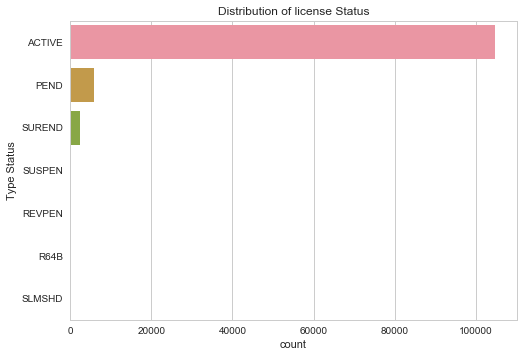

In [11]:
#plot distribution of License status
plt.title("Distribution of license Status")
graph = sns.countplot(y='Type Status', data=gov_data, order=gov_data['Type Status'].value_counts().iloc[:].index)
graph.set_yticklabels(gov_data['Type Status'].value_counts().iloc[:].index, rotation=0);

In [12]:
#Number of unique cities in CA gov_data.
len(gov_data['Premise City'].unique())

1324

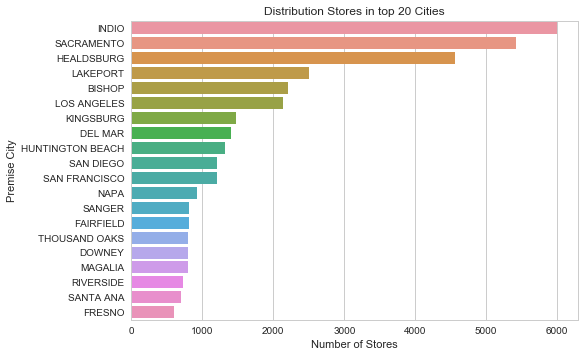

In [13]:
#plot number of stores per city - top 20 cities
plt.title("Distribution Stores in top 20 Cities")
graph = sns.countplot(y='Premise City', data=gov_data, order=gov_data['Premise City'].value_counts().iloc[:20].index)
graph.set_yticklabels(gov_data['Premise City'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Premise City');

In [14]:
#Number of unique zipcode in CA gov_data.
len(gov_data['Premise Zip'].unique())

1815

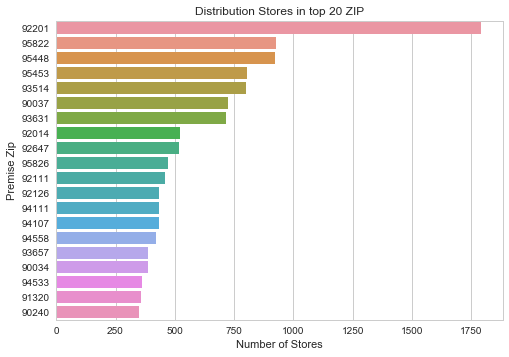

In [15]:
##plot number of stores per zip - top 20 zip
plt.title("Distribution Stores in top 20 ZIP")
graph = sns.countplot(y='Premise Zip', data=gov_data, order=gov_data['Premise Zip'].value_counts().iloc[:20].index)
graph.set_yticklabels(gov_data['Premise Zip'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Premise Zip');

In [16]:
#number of unique counties in CA gov_data
len(gov_data['Premise County'].unique())

58

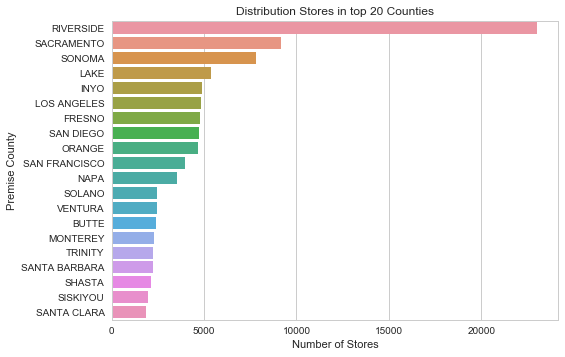

In [17]:
##plot number of stores per county - top 20 counties
plt.title("Distribution Stores in top 20 Counties")
graph = sns.countplot(y='Premise County', data=gov_data, order=gov_data['Premise County'].value_counts().iloc[:20].index)
graph.set_yticklabels(gov_data['Premise County'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Premise County');

In [18]:
#number of unique License type in CA gov_data
len(gov_data['License Type'].unique())

68

In [19]:
#License type
gov_data['License Type'].unique()

array([20, 41,  9, 17, 18, 21, 47, 40, 48,  2, 51, 52, 58, 86, 42, 12, 59,
       77,  4,  6, 10, 14, 81, 68, 49, 64, 22, 15, 57, 50, 55, 11,  3, 63,
       66,  5, 54, 44,  1, 16, 19, 45, 60, 67, 23, 13, 79, 53, 70,  7, 27,
       29, 24, 56, 62, 61, 75, 74, 43, 76, 69, 80, 83, 71, 85, 84,  8, 78], dtype=int64)

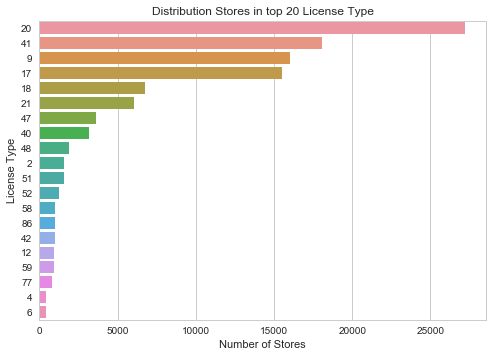

In [20]:
#plot number of stores per license type - top 20 license type
plt.title("Distribution Stores in top 20 License Type")
graph = sns.countplot(y='License Type', data=gov_data, order=gov_data['License Type'].value_counts().iloc[:20].index)
graph.set_yticklabels(gov_data['License Type'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='License Type');

In [21]:
#subset needed columns from gov_data. 
columns = ['License Type', 'File Number','Primary Name', 'Premise Street Address 1', 'Premise Street Address 2','Premise City','Premise State', 'Premise Zip', 'Premise County']
gov_df = gov_data.loc[:,columns]

#change file number and license Type to string
gov_df['File Number'] = gov_df['File Number'].astype(str)
gov_df['License Type'] = gov_df['License Type'].astype(str)
gov_df.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County
0,20,100196,MEZA ALFREDO T,82675 INDIO BLVD,,INDIO,CA,92201,RIVERSIDE
1,20,100275,D MILLER INC,1391 FLORIN RD,,SACRAMENTO,CA,95822,SACRAMENTO
2,41,100297,WYVERN RESTAURANTS INC,1351 HEALDSBURG AVE,,HEALDSBURG,CA,95448,SONOMA
3,41,100298,WYVERN RESTAURANTS INC,821 11TH ST,,LAKEPORT,CA,95453,LAKE
4,9,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,INYO


In [22]:
#create a column called Full_Address to store the full address of a store.
gov_df['Full_Address'] = gov_df['Premise Street Address 1']+ gov_df['Premise Street Address 2'] +" "+gov_df['Premise City'] + " " +gov_df['Premise State']
gov_df.loc[gov_df['Premise Street Address 2']=="",'Full_Address'] = gov_df['Premise Street Address 1']+ " " +gov_df['Premise City'] + " " +gov_df['Premise State']
gov_df.loc[gov_df['Premise Street Address 2']!="",'Full_Address'] = gov_df['Premise Street Address 1']+ " " +gov_df['Premise Street Address 2']+ " "+gov_df['Premise City'] + " " +gov_df['Premise State']

In [23]:
#find rows that has NA value
na_df = gov_df[pd.isnull(gov_df).any(axis=1)]
na_df.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address
4780,47,235949,NaN,1601 VAN NESS AVE,,SAN FRANCISCO,CA,94109,SAN FRANCISCO,1601 VAN NESS AVE SAN FRANCISCO CA
4782,58,235949,NaN,1601 VAN NESS AVE,,SAN FRANCISCO,CA,94109,SAN FRANCISCO,1601 VAN NESS AVE SAN FRANCISCO CA
6480,41,266579,NaN,2555 KILBURN AVE,,NAPA,CA,94558,NAPA,2555 KILBURN AVE NAPA CA
15862,21,355668,NaN,11828 RANCHO BERNARDO RD,STE 108 & 109,SAN DIEGO,CA,92128,SAN DIEGO,11828 RANCHO BERNARDO RD STE 108 & 109 SAN DIE...
15865,86,355668,NaN,11828 RANCHO BERNARDO RD,STE 108 & 109,SAN DIEGO,CA,92128,SAN DIEGO,11828 RANCHO BERNARDO RD STE 108 & 109 SAN DIE...


In [24]:
len(na_df)

277

In [25]:
#There are 227 rows of NA value, and Primary Name has 276 NAs, and Premise City has 1 NA value.
na_df.describe()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address
count,277,277,1,277,277,276,277,277,277,276
unique,17,217,1,178,23,112,1,156,30,177
top,41,530533,SAINT JOHN'S PROGRAM FOR REAL CHANGE,600 F ST,,SAN DIEGO,CA,92101,SAN DIEGO,600 F ST SAN DIEGO CA
freq,62,5,1,10,243,37,277,19,54,10


In [26]:
#Manually fill the NA value with correct Premise City
gov_df.loc[gov_df['Premise City'].isnull()]
gov_df.loc[81892, 'Premise City'] = 'SACRAMENTO'
gov_df.loc[81892, 'Full_Address'] = '1725 L ST SACRAMENTO CA 95811'



#replace NaN values in Primary Name with ''
gov_df['Primary Name'] = gov_df['Primary Name'].replace(np.nan, '', regex=True)

In [27]:
#find rows that has NA value again
na_df = gov_df[pd.isnull(gov_df).any(axis=1)]
na_df.describe()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address
count,0,0,0,0,0,0,0,0,0,0
unique,0,0,0,0,0,0,0,0,0,0


In [28]:
###gov_df=gov_df.dropna(axis=0,how='any')

### SQL DATA from DS_CBBD

In [29]:
SQLstoredata = pd.read_csv('DS_CBBD_CA.csv', encoding='utf-8',dtype=str)
SQLstoredata.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE
0,107525137,BLAZE PIZZA,201 N PALM CANYON DR,NaN,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.825,-116.547
1,107526373,MEIZHOU DONGPO,15363 CULVER DR,NaN,IRVINE,CA,92604,ON PREMISE,OPEN STORE,DINING,ORANGE,33.6947,-117.7981
2,107527101,BERNADETTES BAR,361 S BROADWAY,NaN,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,LOS ANGELES,34.0497,-118.2494
3,105222509,YVES BISTRO,5753 E SANTA ANA CANYON RD STE A,NaN,ANAHEIM,CA,92807,ON PREMISE,OPEN STORE,DINING,ORANGE,33.852,-117.7874
4,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,NaN,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,ORANGE,33.548,-117.7821


In [30]:
len(SQLstoredata)

71690

In [31]:
SQLstoredata.columns

Index(['STORE_CD', 'STORE_DSC', 'ADDR1', 'ADDR2', 'CITY', 'STATE', 'ZIP5',
       'PREMISE_TYPE_DSC', 'STORE_STTS_DSC', 'CHANNEL_DSC', 'FIPS_COUNTY_DSC',
       'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [32]:
SQLstoredata.isnull().sum()

STORE_CD                0
STORE_DSC               0
ADDR1                   0
ADDR2               71690
CITY                    0
STATE                   0
ZIP5                    0
PREMISE_TYPE_DSC        0
STORE_STTS_DSC          0
CHANNEL_DSC             0
FIPS_COUNTY_DSC         0
LATITUDE                0
LONGITUDE               0
dtype: int64

In [33]:
#only ADDR2 has missing value, replace with empty.
SQLstoredata['ADDR2'] = SQLstoredata['ADDR2'].replace(np.nan, '', regex=True)

In [34]:
#Type of License status
SQLstoredata['STORE_STTS_DSC'].unique()

array(['OPEN STORE', 'RECLASSIFIED STORE', 'CLOSED STORE', 'FUTURE STORE'], dtype=object)

In [35]:
#Checking number of stores which are NOT active
len(SQLstoredata.loc[SQLstoredata['STORE_STTS_DSC']!='OPEN STORE'])

print('There are', round(len(SQLstoredata.loc[SQLstoredata['STORE_STTS_DSC']!='OPEN STORE'])/len(SQLstoredata)*100, 1), '% of NOT active licenses')

There are 1.7 % of NOT active licenses


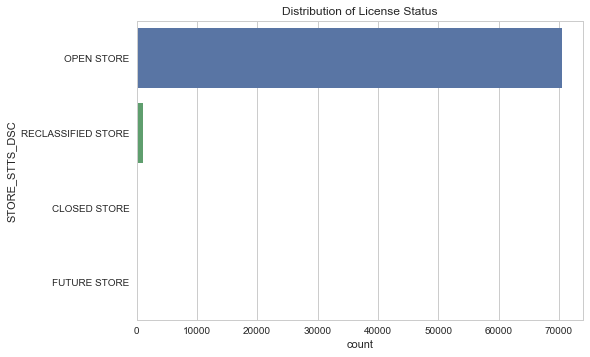

In [36]:
#plot distribution of License status
plt.title("Distribution of License Status")
graph = sns.countplot(y='STORE_STTS_DSC', data=SQLstoredata)
graph.set_yticklabels(SQLstoredata['STORE_STTS_DSC'].unique(), rotation=0);

In [37]:
#Number of unique cities in CA.
len(SQLstoredata['CITY'].unique())
print('gov_data has 1324 unique cities')
print('sql_data has', len(SQLstoredata['CITY'].unique()), 'unique cities')

gov_data has 1324 unique cities
sql_data has 1144 unique cities


In [38]:
#find the cities in sql_data, but are not in gov_data
len(set(SQLstoredata['CITY']) - set(gov_data['Premise City']))

31

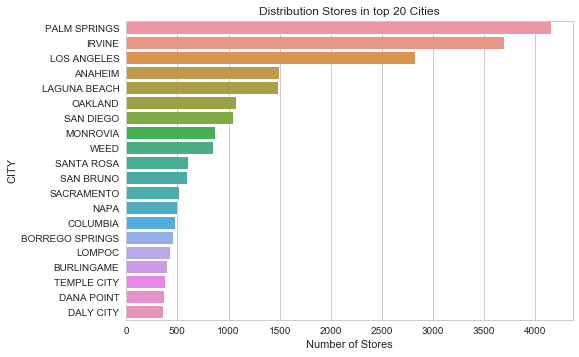

In [39]:
##plot number of stores per city - top 20 cities
plt.title("Distribution Stores in top 20 Cities")
graph = sns.countplot(y='CITY', data=SQLstoredata, order=SQLstoredata['CITY'].value_counts().iloc[:20].index)
graph.set_yticklabels(SQLstoredata['CITY'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='CITY');

In [40]:
#Number of unique zipcode in CA
len(SQLstoredata['ZIP5'].unique())
print('gov_data has 1815 unique zipcodes')
print('sql_data has', len(SQLstoredata['ZIP5'].unique()), 'unique zipcodes')

gov_data has 1815 unique zipcodes
sql_data has 1763 unique zipcodes


In [41]:
#find the zipcode in sql_data, but are not in gov_data
len(set(SQLstoredata['ZIP5']) - set(gov_data['Premise Zip']))

62

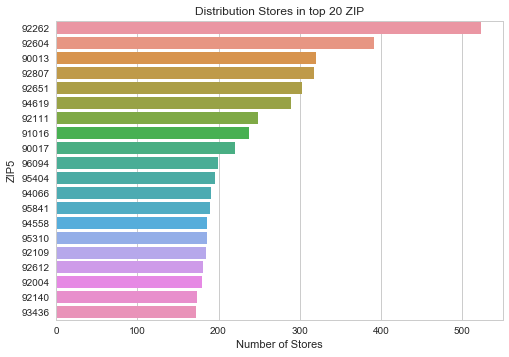

In [42]:
##plot number of stores per zip - top 20 zip
plt.title("Distribution Stores in top 20 ZIP")
graph = sns.countplot(y='ZIP5', data=SQLstoredata, order=SQLstoredata['ZIP5'].value_counts().iloc[:20].index)
graph.set_yticklabels(SQLstoredata['ZIP5'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='ZIP5');

In [43]:
#number of unique counties in CA
len(SQLstoredata['FIPS_COUNTY_DSC'].unique())
#the number of counties in both data are the same

58

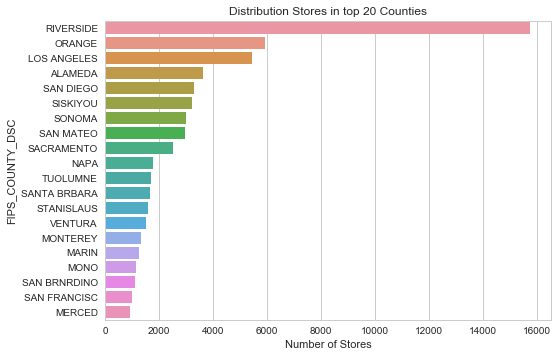

In [44]:
##plot number of stores per counties - top 20 counties
plt.title("Distribution Stores in top 20 Counties")
graph = sns.countplot(y='FIPS_COUNTY_DSC', data=SQLstoredata, order=SQLstoredata['FIPS_COUNTY_DSC'].value_counts().iloc[:20].index)
graph.set_yticklabels(SQLstoredata['FIPS_COUNTY_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='FIPS_COUNTY_DSC');

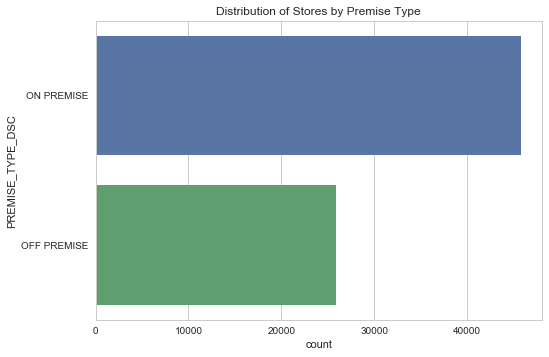

In [45]:
#plot distribution of stores premise type
plt.title("Distribution of Stores by Premise Type")
graph = sns.countplot(y='PREMISE_TYPE_DSC', data=SQLstoredata)
graph.set_yticklabels(SQLstoredata['PREMISE_TYPE_DSC'].unique(), rotation=0);

In [46]:
#Type of Channels in sql_data
SQLstoredata['CHANNEL_DSC'].unique()

array(['DINING', 'BAR/NIGHTCLUB', 'RECREATION', 'CATERER', 'LIQUOR',
       'CONVENIENCE STORE', 'LODGING', 'MILITARY ON-PREMISE',
       'MILITARY OFF-PREMISE', 'TRANSPORTATION', 'GROCERY',
       'MASS MERCHANDISER', 'CIGARETTE OUTLET', 'WHOLESALE CLUB', 'DRUG',
       'EXTENDED MASTER OFF-PREMISE', 'CATEGORY KILLER',
       'EXTENDED MASTER ON-PREMISE'], dtype=object)

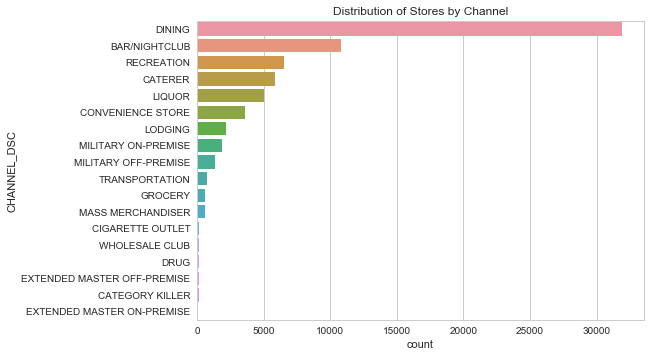

In [47]:
##plot number of stores per channel - top 20 channels
plt.title("Distribution of Stores by Channel")
graph = sns.countplot(y='CHANNEL_DSC', data=SQLstoredata, order=SQLstoredata['CHANNEL_DSC'].value_counts().iloc[:20].index)
graph.set_yticklabels(SQLstoredata['CHANNEL_DSC'].unique(), rotation=0);

In [48]:
#create a column called Full_Address to store the full address of a store.
SQLstoredata['Full_Address'] = SQLstoredata['ADDR1']+ SQLstoredata['ADDR2'] +" "+SQLstoredata['CITY'] + " " +SQLstoredata['STATE']
SQLstoredata.loc[SQLstoredata['ADDR2']=="",'Full_Address'] = SQLstoredata['ADDR1']+ " " +SQLstoredata['CITY'] + " " +SQLstoredata['STATE']
SQLstoredata.loc[SQLstoredata['ADDR2']!="",'Full_Address'] = SQLstoredata['ADDR1']+ " " +SQLstoredata['ADDR2']+ " "+SQLstoredata['CITY'] + " " +SQLstoredata['STATE']


In [49]:
#find rows that has NA value
na_df = SQLstoredata[pd.isnull(SQLstoredata).any(axis=1)]
na_df.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address


### Step2: try 1st approach, directly matching the full address of two dataframe

In [50]:
#create 2 data frames, one store the results that has been matched, the other one stores results that are unmatched.
matched_df=pd.DataFrame()
unmatched_df=SQLstoredata

In [51]:
#directly machthing the full address by left(sql_data) join
merge_df=pd.merge(unmatched_df,gov_df,on='Full_Address',how='left')
merge_df.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,Full_Address,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County
0,107525137,BLAZE PIZZA,201 N PALM CANYON DR,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,201 N PALM CANYON DR PALM SPRINGS CA,41,576984,R&J RESTAURANTS LLC,201 N PALM CANYON DR,,PALM SPRINGS,CA,92262,RIVERSIDE
1,107526373,MEIZHOU DONGPO,15363 CULVER DR,,IRVINE,CA,92604,ON PREMISE,OPEN STORE,DINING,...,15363 CULVER DR IRVINE CA,41,577542,AMERICAN MEIZHOU DONGPO IRVINE INC.,15363 CULVER DR,,IRVINE,CA,92604,ORANGE
2,107527101,BERNADETTES BAR,361 S BROADWAY,,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,...,361 S BROADWAY LOS ANGELES CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,105222509,YVES BISTRO,5753 E SANTA ANA CANYON RD STE A,,ANAHEIM,CA,92807,ON PREMISE,OPEN STORE,DINING,...,5753 E SANTA ANA CANYON RD STE A ANAHEIM CA,47,377968,YVES BISTRO INC,5753 E SANTA ANA CANYON RD,STE A,ANAHEIM,CA,92807,ORANGE
4,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,...,650 LAGUNA CANYON RD LAGUNA BEACH CA,47,434646,TIVOLI TERRACE INC,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ORANGE


In [52]:
#store the matched result into matched_df
matched_df = merge_df.loc[merge_df['File Number'].isnull() == False]

#remove the matched result from unmatched_df and gov_df
unmatched_df=unmatched_df.loc[-unmatched_df['STORE_CD'].isin(matched_df['STORE_CD']),:]
gov_df = gov_df.loc[-gov_df['File Number'].isin(matched_df['File Number']), :]

matched_df.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,Full_Address,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County
0,107525137,BLAZE PIZZA,201 N PALM CANYON DR,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,201 N PALM CANYON DR PALM SPRINGS CA,41,576984,R&J RESTAURANTS LLC,201 N PALM CANYON DR,,PALM SPRINGS,CA,92262,RIVERSIDE
1,107526373,MEIZHOU DONGPO,15363 CULVER DR,,IRVINE,CA,92604,ON PREMISE,OPEN STORE,DINING,...,15363 CULVER DR IRVINE CA,41,577542,AMERICAN MEIZHOU DONGPO IRVINE INC.,15363 CULVER DR,,IRVINE,CA,92604,ORANGE
3,105222509,YVES BISTRO,5753 E SANTA ANA CANYON RD STE A,,ANAHEIM,CA,92807,ON PREMISE,OPEN STORE,DINING,...,5753 E SANTA ANA CANYON RD STE A ANAHEIM CA,47,377968,YVES BISTRO INC,5753 E SANTA ANA CANYON RD,STE A,ANAHEIM,CA,92807,ORANGE
4,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,...,650 LAGUNA CANYON RD LAGUNA BEACH CA,47,434646,TIVOLI TERRACE INC,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ORANGE
5,102914509,FESTIVAL OF ARTS,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ON PREMISE,OPEN STORE,RECREATION,...,650 LAGUNA CANYON RD LAGUNA BEACH CA,77,434646,TIVOLI TERRACE INC,650 LAGUNA CANYON RD,,LAGUNA BEACH,CA,92651,ORANGE


In [53]:
print('There are', round(100 - len(unmatched_df)/len(SQLstoredata)*100,1), 'percent stores that were matched by matching Full_Address')

There are 71.2 percent stores that were matched by matching Full_Address


In [54]:
#number of unmatched stores, 28.8 percent
len(unmatched_df)

20660

### Step3: try 2nd Approach, use function get close match, only for city: NAPA

#### subset data for Napa

In [55]:
napa_unmatched_df = unmatched_df.loc[unmatched_df['CITY'] == 'NAPA', :].reset_index(drop = True)
napa_gov_df = gov_df.loc[gov_df['Premise City'] == 'NAPA', :].reset_index(drop = True)
napa_gov_df.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address
0,2,101022,MONTICELLO CELLARS INC,4242 BIG RANCH RD,,NAPA,CA,94558,NAPA,4242 BIG RANCH RD NAPA CA
1,2,110416,SILVERADO VINEYARDS THE,6121 SILVERADO TRL,,NAPA,CA,94558,NAPA,6121 SILVERADO TRL NAPA CA
2,2,110416,SILVERADO VINEYARDS THE,6121 SILVERADO TRL,,NAPA,CA,94558,NAPA,6121 SILVERADO TRL NAPA CA
3,6,110416,SILVERADO VINEYARDS THE,6121 SILVERADO TRL,,NAPA,CA,94558,NAPA,6121 SILVERADO TRL NAPA CA
4,2,129337,OLDS LAWRENCE L,1500 LOKOYA RD,,NAPA,CA,94558,NAPA,1500 LOKOYA RD NAPA CA


In [56]:
len(napa_unmatched_df)

45

In [57]:
napa_unmatched_df['best1'] = ''
napa_unmatched_df['best1_score'] = ''
napa_unmatched_df['best2'] = ''
napa_unmatched_df['best2_score'] = ''
napa_unmatched_df['best3'] = ''
napa_unmatched_df['best3_score'] = ''

In [58]:
start = time.time()
ratio_list = []

for sql_index in range(len(napa_unmatched_df['Full_Address'])):
    ratio_list = []
    for gov_index in range(len(napa_gov_df['Full_Address'])):
        ratio = Levenshtein.ratio(napa_unmatched_df.loc[sql_index, 'Full_Address'], napa_gov_df.loc[gov_index, 'Full_Address'])
        pairlist = [ratio, napa_gov_df.loc[gov_index, 'Full_Address']]
        ratio_list.append(pairlist)
    
    ratio_list = [list(x) for x in set(tuple(x) for x in ratio_list)]  #find the unique values
    ratio_list = sorted(ratio_list, reverse=True)[0:3]
    
    napa_unmatched_df.loc[sql_index, 'best1'] = ratio_list[0][1]
    napa_unmatched_df.loc[sql_index,'best1_score'] = ratio_list[0][0]
    napa_unmatched_df.loc[sql_index,'best2'] = ratio_list[1][1]
    napa_unmatched_df.loc[sql_index,'best2_score'] = ratio_list[1][0]
    napa_unmatched_df.loc[sql_index,'best3'] = ratio_list[2][1]
    napa_unmatched_df.loc[sql_index,'best3_score'] = ratio_list[2][0]

end = time.time()    
print(end-start)
napa_unmatched_df.head()

3.0515997409820557


,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address,best1,best1_score,best2,best2_score,best3,best3_score
0,101608948,NAPA RIVER INN,500 MAIN ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,LODGING,NAPA,38.2961,-122.2828,500 MAIN ST NAPA CA,604 MAIN ST NAPA CA,0.894737,660 MAIN ST NAPA CA,0.871795,1245 MAIN ST NAPA CA,0.871795
1,107318252,SQUARE ONE,1331 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,NAPA,38.2978,-122.288,1331 1ST ST NAPA CA,1315 1ST ST NAPA CA,0.947368,731 1ST ST NAPA CA,0.918919,1463 1ST ST NAPA CA,0.894737
2,101789187,TR WINES,2545 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,OFF PREMISE,OPEN STORE,LIQUOR,NAPA,38.2554,-122.2745,2545 NAPA VALLEY CORPORATE DR NAPA CA,2515 NAPA VALLEY CORPORATE DR NAPA CA,0.972973,2785 NAPA VALLEY CORPORATE DR NAPA CA,0.945946,2747 NAPA VALLEY CORPORATE DR NAPA CA,0.945946
3,302219888,TONYS KITCHEN,630 AIRPARK RD,,NAPA,CA,94558,ON PREMISE,OPEN STORE,DINING,NAPA,38.2178,-122.2686,630 AIRPARK RD NAPA CA,620 AIRPARK RD NAPA CA,0.954545,607 AIRPARK RD NAPA CA,0.954545,601 AIRPARK RD NAPA CA,0.954545
4,107338972,STUDIO M FINE WINES,1465 1ST ST,,NAPA,CA,94559,OFF PREMISE,OPEN STORE,LIQUOR,NAPA,38.2973,-122.289,1465 1ST ST NAPA CA,1463 1ST ST NAPA CA,0.947368,1461 1ST ST NAPA CA,0.947368,1460 1ST ST NAPA CA,0.947368


In [59]:
#match the name of the stores and set threshold = 0.8
napa_above_thre_df = napa_unmatched_df.loc[napa_unmatched_df['best1_score'] >= 0.80, :]
print('there are',len(napa_above_thre_df), 'stores (out of', len(napa_unmatched_df),'stores) pass threshold 0.8')
napa_above_thre_df.head()

there are 42 stores (out of 45 stores) pass threshold 0.8


,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address,best1,best1_score,best2,best2_score,best3,best3_score
0,101608948,NAPA RIVER INN,500 MAIN ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,LODGING,NAPA,38.2961,-122.2828,500 MAIN ST NAPA CA,604 MAIN ST NAPA CA,0.894737,660 MAIN ST NAPA CA,0.871795,1245 MAIN ST NAPA CA,0.871795
1,107318252,SQUARE ONE,1331 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,NAPA,38.2978,-122.288,1331 1ST ST NAPA CA,1315 1ST ST NAPA CA,0.947368,731 1ST ST NAPA CA,0.918919,1463 1ST ST NAPA CA,0.894737
2,101789187,TR WINES,2545 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,OFF PREMISE,OPEN STORE,LIQUOR,NAPA,38.2554,-122.2745,2545 NAPA VALLEY CORPORATE DR NAPA CA,2515 NAPA VALLEY CORPORATE DR NAPA CA,0.972973,2785 NAPA VALLEY CORPORATE DR NAPA CA,0.945946,2747 NAPA VALLEY CORPORATE DR NAPA CA,0.945946
3,302219888,TONYS KITCHEN,630 AIRPARK RD,,NAPA,CA,94558,ON PREMISE,OPEN STORE,DINING,NAPA,38.2178,-122.2686,630 AIRPARK RD NAPA CA,620 AIRPARK RD NAPA CA,0.954545,607 AIRPARK RD NAPA CA,0.954545,601 AIRPARK RD NAPA CA,0.954545
4,107338972,STUDIO M FINE WINES,1465 1ST ST,,NAPA,CA,94559,OFF PREMISE,OPEN STORE,LIQUOR,NAPA,38.2973,-122.289,1465 1ST ST NAPA CA,1463 1ST ST NAPA CA,0.947368,1461 1ST ST NAPA CA,0.947368,1460 1ST ST NAPA CA,0.947368


In [60]:
check_df = pd.DataFrame()
for each in napa_above_thre_df['best1']:
    tempDF = napa_gov_df.loc[napa_gov_df['Full_Address'] == each, :]
    frames = [check_df, tempDF]
    check_df = pd.concat(frames)
check_df.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address
1843,2,570323,BLACKBIRD VINEYARDS LLC,604 MAIN ST,,NAPA,CA,94559,NAPA,604 MAIN ST NAPA CA
1884,2,571623,MOUNTAIN PEAK VINEYARDS LLC,1315 1ST ST,,NAPA,CA,94559,NAPA,1315 1ST ST NAPA CA
588,2,474599,DA VE WINERY INC,2515 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,NAPA,2515 NAPA VALLEY CORPORATE DR NAPA CA
589,4,474599,DA VE WINERY INC,2515 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,NAPA,2515 NAPA VALLEY CORPORATE DR NAPA CA
590,6,474599,DA VE WINERY INC,2515 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,NAPA,2515 NAPA VALLEY CORPORATE DR NAPA CA


In [61]:
len(check_df)

98

In [62]:
#merge with sql_data to check other features
napa_sql_data = napa_above_thre_df.iloc[:,0:16]
merge_df=pd.merge(napa_sql_data,check_df, left_on='best1',right_on ='Full_Address', how='left')
merge_df.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address_y
0,101608948,NAPA RIVER INN,500 MAIN ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,LODGING,...,2,570323,BLACKBIRD VINEYARDS LLC,604 MAIN ST,,NAPA,CA,94559,NAPA,604 MAIN ST NAPA CA
1,107318252,SQUARE ONE,1331 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,...,2,571623,MOUNTAIN PEAK VINEYARDS LLC,1315 1ST ST,,NAPA,CA,94559,NAPA,1315 1ST ST NAPA CA
2,101789187,TR WINES,2545 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,OFF PREMISE,OPEN STORE,LIQUOR,...,2,474599,DA VE WINERY INC,2515 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,NAPA,2515 NAPA VALLEY CORPORATE DR NAPA CA
3,101789187,TR WINES,2545 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,OFF PREMISE,OPEN STORE,LIQUOR,...,4,474599,DA VE WINERY INC,2515 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,NAPA,2515 NAPA VALLEY CORPORATE DR NAPA CA
4,101789187,TR WINES,2545 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,OFF PREMISE,OPEN STORE,LIQUOR,...,6,474599,DA VE WINERY INC,2515 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,NAPA,2515 NAPA VALLEY CORPORATE DR NAPA CA


In [63]:
merge_df.columns

Index(['STORE_CD', 'STORE_DSC', 'ADDR1', 'ADDR2', 'CITY', 'STATE', 'ZIP5',
       'PREMISE_TYPE_DSC', 'STORE_STTS_DSC', 'CHANNEL_DSC', 'FIPS_COUNTY_DSC',
       'LATITUDE', 'LONGITUDE', 'Full_Address_x', 'best1', 'best1_score',
       'License Type', 'File Number', 'Primary Name',
       'Premise Street Address 1', 'Premise Street Address 2', 'Premise City',
       'Premise State', 'Premise Zip', 'Premise County', 'Full_Address_y'],
      dtype='object')

In [64]:
check_df2 = pd.DataFrame() 
for index in range(len(merge_df)):
    zip_sql = merge_df.loc[index, 'ZIP5']
    zip_gov = merge_df.loc[index, 'Premise Zip']
    county_sql = merge_df.loc[index, 'FIPS_COUNTY_DSC']
    county_gov = merge_df.loc[index, 'Premise County']
    name_sql = merge_df.loc[index, 'STORE_DSC']
    name_gov = merge_df.loc[index, 'Primary Name']
    addr1_sql = merge_df.loc[index, 'ADDR1']
    addr1_gov = merge_df.loc[index, 'Premise Street Address 1']
    
    if Levenshtein.ratio(zip_sql, zip_gov) >= 0.95 and Levenshtein.ratio(county_sql, county_gov)>= 0.95 and Levenshtein.ratio(addr1_sql, addr1_gov)>= 0.9:
        num_sql = re.findall(r'\d+', addr1_sql)
        num_gov = re.findall(r'\d+', addr1_gov)
        if len(num_sql) != 0:
            num_sql = int(num_sql[0])
        else:
            num_sql = 0
        if len(num_gov) != 0:
            num_gov = int(num_gov[0])
        else:
            num_gov = 0
        
        #if the ratio of the store name is greater than 0.5 or the distance street number is less than 10
        if Levenshtein.ratio(name_sql, name_gov) >= 0.5 or abs(num_sql - num_gov) <= 10:
            tempDF = pd.DataFrame(merge_df.loc[index, :]).transpose()
            frames = [check_df2, tempDF]
            check_df2 = pd.concat(frames)
check_df2.head()          

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address_y
23,302219888,TONYS KITCHEN,630 AIRPARK RD,,NAPA,CA,94558,ON PREMISE,OPEN STORE,DINING,...,2,488722,NIEBAUM COPPOLA ESTATE WINERY L PSHIP,620 AIRPARK RD,,NAPA,CA,94558,NAPA,620 AIRPARK RD NAPA CA
32,107373303,ATLAS SOCIAL,1127 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,DINING,...,41,547800,ALL BLUE INC,1124 1ST ST,,NAPA,CA,94559,NAPA,1124 1ST ST NAPA CA
33,107373303,ATLAS SOCIAL,1127 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,DINING,...,41,582289,NAPA NOODLES INC.,1124 1ST ST,,NAPA,CA,94559,NAPA,1124 1ST ST NAPA CA
34,107373303,ATLAS SOCIAL,1127 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,DINING,...,41,547800,ALL BLUE INC,1124 1ST ST,,NAPA,CA,94559,NAPA,1124 1ST ST NAPA CA
35,107373303,ATLAS SOCIAL,1127 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,DINING,...,41,582289,NAPA NOODLES INC.,1124 1ST ST,,NAPA,CA,94559,NAPA,1124 1ST ST NAPA CA


In [65]:
#percentage of matched using Levenshtein
round(len(check_df2['STORE_CD'].unique())/len(napa_unmatched_df['STORE_CD'].unique())*100, 2)

33.33

In [66]:
napa_unmatched_df=napa_unmatched_df.loc[-napa_unmatched_df['STORE_CD'].isin(check_df2['STORE_CD']),:]
len(napa_unmatched_df)

30

In [67]:
len(napa_unmatched_df['STORE_CD'].unique())

30

### Try for PALM SPRINGS(The biggest number of stores)

In [68]:
palm_spr_unmatched_df = unmatched_df.loc[unmatched_df['CITY'] == 'PALM SPRINGS', :].reset_index(drop = True)
palm_spr_gov_df = gov_df.loc[gov_df['Premise City'] == 'PALM SPRINGS', :].reset_index(drop = True)
palm_spr_gov_df.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address
0,47,115482,LE VALLAURIS LMTD,385 W TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,385 W TAHQUITZ CANYON WY PALM SPRINGS CA
1,47,115482,LE VALLAURIS LMTD,385 W TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,385 W TAHQUITZ CANYON WY PALM SPRINGS CA
2,58,115482,LE VALLAURIS LMTD,385 W TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,385 W TAHQUITZ CANYON WY PALM SPRINGS CA
3,58,115482,LE VALLAURIS LMTD,385 W TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,385 W TAHQUITZ CANYON WY PALM SPRINGS CA
4,20,19249,CIRCLE K STORES INC,321 E ARENAS RD,,PALM SPRINGS,CA,92262,RIVERSIDE,321 E ARENAS RD PALM SPRINGS CA


In [69]:
len(palm_spr_unmatched_df)

88

In [70]:
palm_spr_unmatched_df['best1'] = ''
palm_spr_unmatched_df['best1_score'] = ''
palm_spr_unmatched_df['best2'] = ''
palm_spr_unmatched_df['best2_score'] = ''
palm_spr_unmatched_df['best3'] = ''
palm_spr_unmatched_df['best3_score'] = ''

In [71]:
start = time.time()
ratio_list = []

for sql_index in range(len(palm_spr_unmatched_df['Full_Address'])):
    ratio_list = []
    for gov_index in range(len(palm_spr_gov_df['Full_Address'])):
        ratio = Levenshtein.ratio(palm_spr_unmatched_df.loc[sql_index, 'Full_Address'], palm_spr_gov_df.loc[gov_index, 'Full_Address'])
        pairlist = [ratio, palm_spr_gov_df.loc[gov_index, 'Full_Address']]
        ratio_list.append(pairlist)
    
    ratio_list = [list(x) for x in set(tuple(x) for x in ratio_list)]  #find the unique values
    ratio_list = sorted(ratio_list, reverse=True)[0:3]
    
    palm_spr_unmatched_df.loc[sql_index, 'best1'] = ratio_list[0][1]
    palm_spr_unmatched_df.loc[sql_index,'best1_score'] = ratio_list[0][0]
    palm_spr_unmatched_df.loc[sql_index,'best2'] = ratio_list[1][1]
    palm_spr_unmatched_df.loc[sql_index,'best2_score'] = ratio_list[1][0]
    palm_spr_unmatched_df.loc[sql_index,'best3'] = ratio_list[2][1]
    palm_spr_unmatched_df.loc[sql_index,'best3_score'] = ratio_list[2][0]

end = time.time()    
print(end-start)
palm_spr_unmatched_df.head()

0.613800048828125


,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address,best1,best1_score,best2,best2_score,best3,best3_score
0,202521424,SMOKE TREE SUPPER CLUB,1775 E PALM CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.8012,-116.5271,1775 E PALM CANYON DR PALM SPRINGS CA,727 E PALM CANYON DR PALM SPRINGS CA,0.958904,1875 N PALM CANYON DR PALM SPRINGS CA,0.945946,1586 E PALM CANYON DR PALM SPRINGS CA,0.945946
1,102511413,FRANKINBUN,540 S INDIAN CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.8149,-116.5455,540 S INDIAN CANYON DR PALM SPRINGS CA,540 S INDIAN CANYON DRIVE PALM SPRINGS CA,0.962025,350-52 S INDIAN CANYON DR PALM SPRINGS CA,0.936709,100 N INDIAN CANYON DR PALM SPRINGS CA,0.921053
2,105520322,SHERMANS DELI & BAKERY,401 E TAHQUITZ CANYON WAY,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.8229,-116.5427,401 E TAHQUITZ CANYON WAY PALM SPRINGS CA,400 E TAHQUITZ CANYON WY PALM SPRINGS CA,0.962963,401-23 E TAHQUITZ CANYON WY PALM SPRINGS CA,0.952381,412 W TAHQUITZ CANYON WY PALM SPRINGS CA,0.938272
3,107362396,MOOD,901 N PALM CANYON DR,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,RECREATION,RIVERSIDE,33.8355,-116.5469,901 N PALM CANYON DR PALM SPRINGS CA,1900 N PALM CANYON DR PALM SPRINGS CA,0.958904,111 N PALM CANYON DR PALM SPRINGS CA,0.944444,2796 N PALM CANYON DR PALM SPRINGS CA,0.931507
4,307070377,CHICKEN RANCH,515 N PALM CANYON DR,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.8307,-116.547,515 N PALM CANYON DR PALM SPRINGS CA,1875 N PALM CANYON DR PALM SPRINGS CA,0.958904,111 N PALM CANYON DR PALM SPRINGS CA,0.944444,1900 N PALM CANYON DR PALM SPRINGS CA,0.931507


In [72]:
#match the name of the stores and set threshold = 0.8
palm_spr_above_thre_df = palm_spr_unmatched_df.loc[palm_spr_unmatched_df['best1_score'] >= 0.80, :]
print('there are',len(palm_spr_above_thre_df), 'stores (out of', len(palm_spr_unmatched_df),'stores) pass threshold 0.8')
palm_spr_above_thre_df.head()

there are 81 stores (out of 88 stores) pass threshold 0.8


,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address,best1,best1_score,best2,best2_score,best3,best3_score
0,202521424,SMOKE TREE SUPPER CLUB,1775 E PALM CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.8012,-116.5271,1775 E PALM CANYON DR PALM SPRINGS CA,727 E PALM CANYON DR PALM SPRINGS CA,0.958904,1875 N PALM CANYON DR PALM SPRINGS CA,0.945946,1586 E PALM CANYON DR PALM SPRINGS CA,0.945946
1,102511413,FRANKINBUN,540 S INDIAN CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.8149,-116.5455,540 S INDIAN CANYON DR PALM SPRINGS CA,540 S INDIAN CANYON DRIVE PALM SPRINGS CA,0.962025,350-52 S INDIAN CANYON DR PALM SPRINGS CA,0.936709,100 N INDIAN CANYON DR PALM SPRINGS CA,0.921053
2,105520322,SHERMANS DELI & BAKERY,401 E TAHQUITZ CANYON WAY,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.8229,-116.5427,401 E TAHQUITZ CANYON WAY PALM SPRINGS CA,400 E TAHQUITZ CANYON WY PALM SPRINGS CA,0.962963,401-23 E TAHQUITZ CANYON WY PALM SPRINGS CA,0.952381,412 W TAHQUITZ CANYON WY PALM SPRINGS CA,0.938272
3,107362396,MOOD,901 N PALM CANYON DR,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,RECREATION,RIVERSIDE,33.8355,-116.5469,901 N PALM CANYON DR PALM SPRINGS CA,1900 N PALM CANYON DR PALM SPRINGS CA,0.958904,111 N PALM CANYON DR PALM SPRINGS CA,0.944444,2796 N PALM CANYON DR PALM SPRINGS CA,0.931507
4,307070377,CHICKEN RANCH,515 N PALM CANYON DR,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,RIVERSIDE,33.8307,-116.547,515 N PALM CANYON DR PALM SPRINGS CA,1875 N PALM CANYON DR PALM SPRINGS CA,0.958904,111 N PALM CANYON DR PALM SPRINGS CA,0.944444,1900 N PALM CANYON DR PALM SPRINGS CA,0.931507


In [73]:
check_df = pd.DataFrame()
for each in palm_spr_above_thre_df['best1']:
    tempDF = palm_spr_gov_df.loc[palm_spr_gov_df['Full_Address'] == each, :]
    frames = [check_df, tempDF]
    check_df = pd.concat(frames)
check_df.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address
30,47,371482,PALMDEN RESTAURANTS LLC,727 E PALM CANYON DR,,PALM SPRINGS,CA,92264,RIVERSIDE,727 E PALM CANYON DR PALM SPRINGS CA
132,41,563333,FRANKINBUN LLC,540 S INDIAN CANYON DRIVE,,PALM SPRINGS,CA,92264,RIVERSIDE,540 S INDIAN CANYON DRIVE PALM SPRINGS CA
6,47,228854,WALTER FAMILY PARTNERSHIP L-PSHIP,400 E TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,400 E TAHQUITZ CANYON WY PALM SPRINGS CA
7,58,228854,WALTER FAMILY PARTNERSHIP L-PSHIP,400 E TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,400 E TAHQUITZ CANYON WY PALM SPRINGS CA
8,68,228854,WALTER FAMILY PARTNERSHIP L-PSHIP,400 E TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,400 E TAHQUITZ CANYON WY PALM SPRINGS CA


In [74]:
#merge with sql_data to check other features
palm_spr_sql_data = palm_spr_above_thre_df.iloc[:,0:16]
merge_df=pd.merge(palm_spr_sql_data,check_df, left_on='best1',right_on ='Full_Address', how='left')
merge_df.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address_y
0,202521424,SMOKE TREE SUPPER CLUB,1775 E PALM CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,...,47,371482,PALMDEN RESTAURANTS LLC,727 E PALM CANYON DR,,PALM SPRINGS,CA,92264,RIVERSIDE,727 E PALM CANYON DR PALM SPRINGS CA
1,202521424,SMOKE TREE SUPPER CLUB,1775 E PALM CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,...,47,371482,PALMDEN RESTAURANTS LLC,727 E PALM CANYON DR,,PALM SPRINGS,CA,92264,RIVERSIDE,727 E PALM CANYON DR PALM SPRINGS CA
2,202521424,SMOKE TREE SUPPER CLUB,1775 E PALM CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,...,47,371482,PALMDEN RESTAURANTS LLC,727 E PALM CANYON DR,,PALM SPRINGS,CA,92264,RIVERSIDE,727 E PALM CANYON DR PALM SPRINGS CA
3,102511413,FRANKINBUN,540 S INDIAN CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,...,41,563333,FRANKINBUN LLC,540 S INDIAN CANYON DRIVE,,PALM SPRINGS,CA,92264,RIVERSIDE,540 S INDIAN CANYON DRIVE PALM SPRINGS CA
4,105520322,SHERMANS DELI & BAKERY,401 E TAHQUITZ CANYON WAY,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,47,228854,WALTER FAMILY PARTNERSHIP L-PSHIP,400 E TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,400 E TAHQUITZ CANYON WY PALM SPRINGS CA


In [75]:
check_df2 = pd.DataFrame() 
for index in range(len(merge_df)):
    zip_sql = merge_df.loc[index, 'ZIP5']
    zip_gov = merge_df.loc[index, 'Premise Zip']
    county_sql = merge_df.loc[index, 'FIPS_COUNTY_DSC']
    county_gov = merge_df.loc[index, 'Premise County']
    name_sql = merge_df.loc[index, 'STORE_DSC']
    name_gov = merge_df.loc[index, 'Primary Name']
    addr1_sql = merge_df.loc[index, 'ADDR1']
    addr1_gov = merge_df.loc[index, 'Premise Street Address 1']
    
    if Levenshtein.ratio(zip_sql, zip_gov) >= 0.95 and Levenshtein.ratio(county_sql, county_gov)>= 0.95 and Levenshtein.ratio(addr1_sql, addr1_gov)>= 0.9:
        num_sql = re.findall(r'\d+', addr1_sql)
        num_gov = re.findall(r'\d+', addr1_gov)
        if len(num_sql) != 0:
            num_sql = int(num_sql[0])
        else:
            num_sql = 0
        if len(num_gov) != 0:
            num_gov = int(num_gov[0])
        else:
            num_gov = 0
        #if the ratio of the store name is greater than 0.5 or the distance street number is less than 10
        if Levenshtein.ratio(name_sql, name_gov) >= 0.5 or abs(num_sql - num_gov) <= 10:
            tempDF = pd.DataFrame(merge_df.loc[index, :]).transpose()
            frames = [check_df2, tempDF]
            check_df2 = pd.concat(frames)
check_df2.head()          

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address_y
3,102511413,FRANKINBUN,540 S INDIAN CANYON DR,,PALM SPRINGS,CA,92264,ON PREMISE,OPEN STORE,DINING,...,41,563333,FRANKINBUN LLC,540 S INDIAN CANYON DRIVE,,PALM SPRINGS,CA,92264,RIVERSIDE,540 S INDIAN CANYON DRIVE PALM SPRINGS CA
4,105520322,SHERMANS DELI & BAKERY,401 E TAHQUITZ CANYON WAY,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,47,228854,WALTER FAMILY PARTNERSHIP L-PSHIP,400 E TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,400 E TAHQUITZ CANYON WY PALM SPRINGS CA
5,105520322,SHERMANS DELI & BAKERY,401 E TAHQUITZ CANYON WAY,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,58,228854,WALTER FAMILY PARTNERSHIP L-PSHIP,400 E TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,400 E TAHQUITZ CANYON WY PALM SPRINGS CA
6,105520322,SHERMANS DELI & BAKERY,401 E TAHQUITZ CANYON WAY,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,68,228854,WALTER FAMILY PARTNERSHIP L-PSHIP,400 E TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,400 E TAHQUITZ CANYON WY PALM SPRINGS CA
7,105520322,SHERMANS DELI & BAKERY,401 E TAHQUITZ CANYON WAY,,PALM SPRINGS,CA,92262,ON PREMISE,OPEN STORE,DINING,...,47,228854,WALTER FAMILY PARTNERSHIP L-PSHIP,400 E TAHQUITZ CANYON WY,,PALM SPRINGS,CA,92262,RIVERSIDE,400 E TAHQUITZ CANYON WY PALM SPRINGS CA


In [76]:
#percentage of matched using Levenshtein
round(len(check_df2['STORE_CD'].unique())/len(palm_spr_unmatched_df['STORE_CD'].unique())*100, 2)

32.95

### Try los angeles

In [99]:
la_unmatched_df = unmatched_df.loc[unmatched_df['CITY'] == 'LOS ANGELES', :].reset_index(drop = True)
la_gov_df = gov_df.loc[gov_df['Premise City'] == 'LOS ANGELES', :].reset_index(drop = True)
print('length of the dataframe:', len(la_unmatched_df))
la_unmatched_df['best1'] = ''
la_unmatched_df['best1_score'] = ''
la_unmatched_df['best2'] = ''
la_unmatched_df['best2_score'] = ''
la_unmatched_df['best3'] = ''
la_unmatched_df['best3_score'] = ''

length of the dataframe: 1417


In [100]:
start = time.time()
ratio_list = []

for sql_index in range(len(la_unmatched_df['Full_Address'])):
    ratio_list = []
    for gov_index in range(len(la_gov_df['Full_Address'])):
        ratio = Levenshtein.ratio(la_unmatched_df.loc[sql_index, 'Full_Address'], la_gov_df.loc[gov_index, 'Full_Address'])
        pairlist = [ratio, la_gov_df.loc[gov_index, 'Full_Address']]
        ratio_list.append(pairlist)
    
    ratio_list = [list(x) for x in set(tuple(x) for x in ratio_list)]  #find the unique values
    ratio_list = sorted(ratio_list, reverse=True)[0:3]
    
    la_unmatched_df.loc[sql_index, 'best1'] = ratio_list[0][1]
    la_unmatched_df.loc[sql_index,'best1_score'] = ratio_list[0][0]
    la_unmatched_df.loc[sql_index,'best2'] = ratio_list[1][1]
    la_unmatched_df.loc[sql_index,'best2_score'] = ratio_list[1][0]
    la_unmatched_df.loc[sql_index,'best3'] = ratio_list[2][1]
    la_unmatched_df.loc[sql_index,'best3_score'] = ratio_list[2][0]

end = time.time()    
print(end-start)
la_unmatched_df.head()

124.97360014915466


,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address,best1,best1_score,best2,best2_score,best3,best3_score
0,107527101,BERNADETTES BAR,361 S BROADWAY,,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,LOS ANGELES,34.0497,-118.2494,361 S BROADWAY LOS ANGELES CA,618 S BROADWAY LOS ANGELES CA,0.965517,361 S BROADWAY ST LOS ANGELES CA,0.95082,3510 S BROADWAY LOS ANGELES CA,0.949153
1,107526290,GIULIA,701 W 7TH ST,,LOS ANGELES,CA,90017,ON PREMISE,OPEN STORE,DINING,LOS ANGELES,34.0482,-118.2577,701 W 7TH ST LOS ANGELES CA,3014 W 7TH ST LOS ANGELES CA,0.945455,2700 W 7TH ST LOS ANGELES CA,0.945455,101 W 5TH ST LOS ANGELES CA,0.925926
2,107373520,WILSHIRE FATBURGER,3150 WILSHIRE BLVD,,LOS ANGELES,CA,90010,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,LOS ANGELES,34.0617,-118.2905,3150 WILSHIRE BLVD LOS ANGELES CA,3950 WILSHIRE BLVD LOS ANGELES CA,0.969697,11750 WILSHIRE BLVD LOS ANGELES CA,0.955224,6101 WILSHIRE BLVD LOS ANGELES CA,0.939394
3,103928439,7 ELEVEN,818 W 7TH ST,,LOS ANGELES,CA,90017,OFF PREMISE,OPEN STORE,CONVENIENCE STORE,LOS ANGELES,34.0489,-118.2595,818 W 7TH ST LOS ANGELES CA,2818 W 9TH ST LOS ANGELES CA,0.945455,3014 W 7TH ST LOS ANGELES CA,0.909091,1728-1738 W 7TH ST LOS ANGELES CA,0.9
4,107349432,SNA GENERAL DISCOUNT & MARKET,9522 S FIGUEROA ST,,LOS ANGELES,CA,90003,OFF PREMISE,OPEN STORE,CONVENIENCE STORE,LOS ANGELES,33.9498,-118.2825,9522 S FIGUEROA ST LOS ANGELES CA,940 S FIGUEROA ST LOS ANGELES CA,0.923077,15300 S FIGUEROA ST LOS ANGELES CA,0.895522,5629 1/2 N FIGUEROA ST LOS ANGELES CA,0.885714


In [101]:
#match the name of the stores and set threshold = 0.8
la_above_thre_df = la_unmatched_df.loc[la_unmatched_df['best1_score'] >= 0.80, :]
print('there are',len(la_above_thre_df), 'stores (out of', len(la_unmatched_df),'stores) pass threshold 0.8')
la_above_thre_df.head()

there are 1398 stores (out of 1417 stores) pass threshold 0.8


,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address,best1,best1_score,best2,best2_score,best3,best3_score
0,107527101,BERNADETTES BAR,361 S BROADWAY,,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,LOS ANGELES,34.0497,-118.2494,361 S BROADWAY LOS ANGELES CA,618 S BROADWAY LOS ANGELES CA,0.965517,361 S BROADWAY ST LOS ANGELES CA,0.95082,3510 S BROADWAY LOS ANGELES CA,0.949153
1,107526290,GIULIA,701 W 7TH ST,,LOS ANGELES,CA,90017,ON PREMISE,OPEN STORE,DINING,LOS ANGELES,34.0482,-118.2577,701 W 7TH ST LOS ANGELES CA,3014 W 7TH ST LOS ANGELES CA,0.945455,2700 W 7TH ST LOS ANGELES CA,0.945455,101 W 5TH ST LOS ANGELES CA,0.925926
2,107373520,WILSHIRE FATBURGER,3150 WILSHIRE BLVD,,LOS ANGELES,CA,90010,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,LOS ANGELES,34.0617,-118.2905,3150 WILSHIRE BLVD LOS ANGELES CA,3950 WILSHIRE BLVD LOS ANGELES CA,0.969697,11750 WILSHIRE BLVD LOS ANGELES CA,0.955224,6101 WILSHIRE BLVD LOS ANGELES CA,0.939394
3,103928439,7 ELEVEN,818 W 7TH ST,,LOS ANGELES,CA,90017,OFF PREMISE,OPEN STORE,CONVENIENCE STORE,LOS ANGELES,34.0489,-118.2595,818 W 7TH ST LOS ANGELES CA,2818 W 9TH ST LOS ANGELES CA,0.945455,3014 W 7TH ST LOS ANGELES CA,0.909091,1728-1738 W 7TH ST LOS ANGELES CA,0.9
4,107349432,SNA GENERAL DISCOUNT & MARKET,9522 S FIGUEROA ST,,LOS ANGELES,CA,90003,OFF PREMISE,OPEN STORE,CONVENIENCE STORE,LOS ANGELES,33.9498,-118.2825,9522 S FIGUEROA ST LOS ANGELES CA,940 S FIGUEROA ST LOS ANGELES CA,0.923077,15300 S FIGUEROA ST LOS ANGELES CA,0.895522,5629 1/2 N FIGUEROA ST LOS ANGELES CA,0.885714


In [102]:
check_df = pd.DataFrame()
for each in la_above_thre_df['best1']:
    tempDF = la_gov_df.loc[la_gov_df['Full_Address'] == each, :]
    frames = [check_df, tempDF]
    check_df = pd.concat(frames)
check_df.head()

#merge with sql_data to check other features
la_sql_data = la_above_thre_df.iloc[:,0:16]
merge_df=pd.merge(la_sql_data,check_df, left_on='best1',right_on ='Full_Address', how='left')
merge_df.head()

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address_y,MODIFY CITY,isChange
0,107527101,BERNADETTES BAR,361 S BROADWAY,,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,...,2 U TURN RESTAURANT LLC,618 S BROADWAY,,LOS ANGELES,CA,90014,LOS ANGELES,618 S BROADWAY LOS ANGELES CA,LOS ANGELES,False
1,107527101,BERNADETTES BAR,361 S BROADWAY,,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,...,2 U TURN RESTAURANT LLC,618 S BROADWAY,,LOS ANGELES,CA,90014,LOS ANGELES,618 S BROADWAY LOS ANGELES CA,LOS ANGELES,False
2,107527101,BERNADETTES BAR,361 S BROADWAY,,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,...,2 U TURN RESTAURANT LLC,618 S BROADWAY,,LOS ANGELES,CA,90014,LOS ANGELES,618 S BROADWAY LOS ANGELES CA,LOS ANGELES,False
3,107527101,BERNADETTES BAR,361 S BROADWAY,,LOS ANGELES,CA,90013,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,...,2 U TURN RESTAURANT LLC,618 S BROADWAY,,LOS ANGELES,CA,90014,LOS ANGELES,618 S BROADWAY LOS ANGELES CA,LOS ANGELES,False
4,107526290,GIULIA,701 W 7TH ST,,LOS ANGELES,CA,90017,ON PREMISE,OPEN STORE,DINING,...,DAEJANGKUM ENTERPRISE INC,3014 W 7TH ST,,LOS ANGELES,CA,90005,LOS ANGELES,3014 W 7TH ST LOS ANGELES CA,LOS ANGELES,False


In [103]:
check_df2 = pd.DataFrame() 
for index in range(len(merge_df)):
    zip_sql = merge_df.loc[index, 'ZIP5']
    zip_gov = merge_df.loc[index, 'Premise Zip']
    county_sql = merge_df.loc[index, 'FIPS_COUNTY_DSC']
    county_gov = merge_df.loc[index, 'Premise County']
    name_sql = merge_df.loc[index, 'STORE_DSC']
    name_gov = merge_df.loc[index, 'Primary Name']
    addr1_sql = merge_df.loc[index, 'ADDR1']
    addr1_gov = merge_df.loc[index, 'Premise Street Address 1']
    
    if Levenshtein.ratio(zip_sql, zip_gov) >= 0.95 and Levenshtein.ratio(county_sql, county_gov)>= 0.95 and Levenshtein.ratio(addr1_sql, addr1_gov)>= 0.9:
        num_sql = re.findall(r'\d+', addr1_sql)
        num_gov = re.findall(r'\d+', addr1_gov)
        if len(num_sql) != 0:
            num_sql = int(num_sql[0])
        else:
            num_sql = 0
        if len(num_gov) != 0:
            num_gov = int(num_gov[0])
        else:
            num_gov = 0
        #if the ratio of the store name is greater than 0.5 or the distance street number is less than 10
        if Levenshtein.ratio(name_sql, name_gov) >= 0.5 or abs(num_sql - num_gov) <= 10:
            tempDF = pd.DataFrame(merge_df.loc[index, :]).transpose()
            frames = [check_df2, tempDF]
            check_df2 = pd.concat(frames)
check_df2.head()  

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address_y,MODIFY CITY,isChange
66,107474985,GRAND CENTRAL MARKET,317 S BROADWAY,,LOS ANGELES,CA,90013,OFF PREMISE,OPEN STORE,GROCERY,...,BOMBO FOODS LA LLC,317 S BROADWAY,D3,LOS ANGELES,CA,90013,LOS ANGELES,317 S BROADWAY D3 LOS ANGELES CA,LOS ANGELES,False
67,107474985,GRAND CENTRAL MARKET,317 S BROADWAY,,LOS ANGELES,CA,90013,OFF PREMISE,OPEN STORE,GROCERY,...,BOMBO FOODS LA LLC,317 S BROADWAY,D3,LOS ANGELES,CA,90013,LOS ANGELES,317 S BROADWAY D3 LOS ANGELES CA,LOS ANGELES,False
68,107474985,GRAND CENTRAL MARKET,317 S BROADWAY,,LOS ANGELES,CA,90013,OFF PREMISE,OPEN STORE,GROCERY,...,BOMBO FOODS LA LLC,317 S BROADWAY,D3,LOS ANGELES,CA,90013,LOS ANGELES,317 S BROADWAY D3 LOS ANGELES CA,LOS ANGELES,False
69,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False
70,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False


In [84]:
#percentage of matched using Levenshtein
round(len(check_df2['STORE_CD'].unique())/len(la_unmatched_df['STORE_CD'].unique())*100, 2)

23.15

In [105]:
check_df2

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,...,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address_y,MODIFY CITY,isChange
66,107474985,GRAND CENTRAL MARKET,317 S BROADWAY,,LOS ANGELES,CA,90013,OFF PREMISE,OPEN STORE,GROCERY,...,BOMBO FOODS LA LLC,317 S BROADWAY,D3,LOS ANGELES,CA,90013,LOS ANGELES,317 S BROADWAY D3 LOS ANGELES CA,LOS ANGELES,False
67,107474985,GRAND CENTRAL MARKET,317 S BROADWAY,,LOS ANGELES,CA,90013,OFF PREMISE,OPEN STORE,GROCERY,...,BOMBO FOODS LA LLC,317 S BROADWAY,D3,LOS ANGELES,CA,90013,LOS ANGELES,317 S BROADWAY D3 LOS ANGELES CA,LOS ANGELES,False
68,107474985,GRAND CENTRAL MARKET,317 S BROADWAY,,LOS ANGELES,CA,90013,OFF PREMISE,OPEN STORE,GROCERY,...,BOMBO FOODS LA LLC,317 S BROADWAY,D3,LOS ANGELES,CA,90013,LOS ANGELES,317 S BROADWAY D3 LOS ANGELES CA,LOS ANGELES,False
69,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False
70,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False
71,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False
72,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False
73,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False
74,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False
75,103869611,WOLFGANG PUCK CATERING,5515 WILSHIRE BLVD,,LOS ANGELES,CA,90036,ON PREMISE,OPEN STORE,CATERER,...,WOLFGANG PUCK CATERING & EVENTS LLC,5515-17 WILSHIRE BLVD,,LOS ANGELES,CA,90036,LOS ANGELES,5515-17 WILSHIRE BLVD LOS ANGELES CA,LOS ANGELES,False


## Dedupe 

In [ ]:
#Uses Hamming distance. It counts the number of substitutions that must be made to turn one string into another

#affine gap penalty: gap penalty function. It combines the components in both the constant and linear gap penalty. 
#terms: gap opening penalty, gap extension penalty, length of the gap
#Gap opening refers to the cost required to open a gap of any length, 
#gap extension the cost to extend the length of an existing gap by 1.
#In general, if the interest is to find closely related matches, a higher gap penalty should be used to reduce gap openings.
#On the other hand,  gap penalty should be lowered when interested in finding a more distant match.

#can also add weights to different string

In [108]:
#!pip install dedupe

  Using cached dedupe-1.7.0.tar.gz
  Using cached dedupe-hcluster-0.3.2.tar.gz
  Using cached affinegap-1.10.tar.gz
  Using cached categorical_distance-1.9-py3-none-any.whl
  Using cached dedupe_variable_datetime-0.1.4-py3-none-any.whl
  Using cached rlr-2.4.3-py2.py3-none-any.whl
  Using cached DoubleMetaphone-0.1.tar.gz
  Using cached highered-0.2.1-py2.py3-none-any.whl
  Using cached canonicalize-1.3-py3-none-any.whl
  Using cached simplecosine-1.2-py2.py3-none-any.whl
  Using cached BTrees-4.4.1-cp36-cp36m-win_amd64.whl
  Using cached zope.index-4.3.0-cp36-cp36m-win_amd64.whl
  Using cached Levenshtein_search-1.4.4-cp36-cp36m-win_amd64.whl
  Using cached datetime_distance-0.1.3-py3-none-any.whl
  Using cached PyLBFGS-0.2.0.5.tar.gz
  Using cached pyhacrf-datamade-0.2.1.tar.gz
  Using cached zope.interface-4.4.2-cp36-cp36m-win_amd64.whl
  Using cached persistent-4.2.4.2-cp36-cp36m-win_amd64.whl
  Running setup.py bdist_wheel for dedupe: started
  Running setup.py bdist_wheel for ded

  Failed building wheel for dedupe
  Failed building wheel for dedupe-hcluster
  Failed building wheel for affinegap
  Failed building wheel for doublemetaphone
  Failed building wheel for pylbfgs
  Failed building wheel for pyhacrf-datamade
Command "C:\Users\qguo\AppData\Local\Continuum\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\qguo\\AppData\\Local\\Temp\\pip-build-8i740ceb\\dedupe-hcluster\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\qguo\AppData\Local\Temp\pip-5ong2ay4-record\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\qguo\AppData\Local\Temp\pip-build-8i740ceb\dedupe-hcluster\


ModuleNotFoundError: No module named 'dedupe'

In [86]:
napa_unmatched_df.loc[0:5, :]

,STORE_CD,STORE_DSC,ADDR1,ADDR2,CITY,STATE,ZIP5,PREMISE_TYPE_DSC,STORE_STTS_DSC,CHANNEL_DSC,FIPS_COUNTY_DSC,LATITUDE,LONGITUDE,Full_Address,best1,best1_score,best2,best2_score,best3,best3_score
0,101608948,NAPA RIVER INN,500 MAIN ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,LODGING,NAPA,38.2961,-122.2828,500 MAIN ST NAPA CA,604 MAIN ST NAPA CA,0.894737,660 MAIN ST NAPA CA,0.871795,1245 MAIN ST NAPA CA,0.871795
1,107318252,SQUARE ONE,1331 1ST ST,,NAPA,CA,94559,ON PREMISE,OPEN STORE,BAR/NIGHTCLUB,NAPA,38.2978,-122.288,1331 1ST ST NAPA CA,1315 1ST ST NAPA CA,0.947368,731 1ST ST NAPA CA,0.918919,1463 1ST ST NAPA CA,0.894737
2,101789187,TR WINES,2545 NAPA VALLEY CORPORATE DR,,NAPA,CA,94558,OFF PREMISE,OPEN STORE,LIQUOR,NAPA,38.2554,-122.2745,2545 NAPA VALLEY CORPORATE DR NAPA CA,2515 NAPA VALLEY CORPORATE DR NAPA CA,0.972973,2785 NAPA VALLEY CORPORATE DR NAPA CA,0.945946,2747 NAPA VALLEY CORPORATE DR NAPA CA,0.945946
4,107338972,STUDIO M FINE WINES,1465 1ST ST,,NAPA,CA,94559,OFF PREMISE,OPEN STORE,LIQUOR,NAPA,38.2973,-122.289,1465 1ST ST NAPA CA,1463 1ST ST NAPA CA,0.947368,1461 1ST ST NAPA CA,0.947368,1460 1ST ST NAPA CA,0.947368
5,103688422,TACOS MICHOACAN,721 LINCOLN AVE,,NAPA,CA,94558,ON PREMISE,OPEN STORE,DINING,NAPA,38.3099,-122.2864,721 LINCOLN AVE NAPA CA,851 LINCOLN AVE NAPA CA,0.913043,945 LINCOLN AVE NAPA CA,0.869565,2025 W LINCOLN AVE NAPA CA,0.857143


In [87]:
napa_gov_df.loc[napa_gov_df['Premise Street Address 1'] == '500 MAIN ST', :]

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address


In [88]:
Best_Address[0:5]

[[],
 [],
 ['2515 NAPA VALLEY CORPORATE DR NAPA CA',
  '2515 NAPA VALLEY CORPORATE DR NAPA CA',
  '2515 NAPA VALLEY CORPORATE DR NAPA CA',
  '2515 NAPA VALLEY CORPORATE DR NAPA CA',
  '2515 NAPA VALLEY CORPORATE DR NAPA CA'],
 [],
 []]

In [89]:
fuzzy_df=napa_unmatched_df
Best_Address=[]

start = time.time()

for address in napa_unmatched_df['Full_Address']:
    address_match_list=get_close_matches(address,list(napa_gov_df['Full_Address']),n=1,cutoff=0.95)
    Best_Address.append(address_match_list)

end = time.time()    
print(end-start)

0.25239992141723633


In [90]:
Best_Address

[[],
 [],
 ['2515 NAPA VALLEY CORPORATE DR NAPA CA'],
 [],
 [],
 [],
 [],
 ['1000 MAIN ST STE 150 NAPA CA'],
 [],
 [],
 ['2515 NAPA VALLEY CORPORATE DR NAPA CA'],
 [],
 ['902 ENTERPRISE WAY STE P NAPA CA'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 []]

In [91]:
unique_city = list(SQLstoredata['CITY'].unique())
unique_city

['PALM SPRINGS',
 'IRVINE',
 'LOS ANGELES',
 'ANAHEIM',
 'LAGUNA BEACH',
 'OAKLAND',
 'SAN DIEGO',
 'MONROVIA',
 'WEED',
 'SANTA ROSA',
 'SAN BRUNO',
 'SACRAMENTO',
 'NAPA',
 'COLUMBIA',
 'BORREGO SPRINGS',
 'LOMPOC',
 'BURLINGAME',
 'TEMPLE CITY',
 'DANA POINT',
 'DALY CITY',
 'MODESTO',
 'THOUSAND OAKS',
 'PEBBLE BEACH',
 'SAN RAFAEL',
 'CYPRESS',
 'GLENDALE',
 'BRIDGEPORT',
 'PASADENA',
 'MALIBU',
 'GARDEN GROVE',
 'EL CAJON',
 'BUENA PARK',
 'REDLANDS',
 'SAN FRANCISCO',
 'SAN BERNARDINO',
 'MERCED',
 'PISMO BEACH',
 'RIVERSIDE',
 'GARDENA',
 'SANTA MONICA',
 'ROSEMEAD',
 'HUNTINGTON BEACH',
 'BELL',
 'FRESNO',
 'SAN LUIS OBISPO',
 'CITRUS HEIGHTS',
 'HAYWARD',
 'GRAND TERRACE',
 'INGLEWOOD',
 'WEST HOLLYWOOD',
 'EL CENTRO',
 'PLEASANT HILL',
 'SANTA ANA',
 'VENTURA',
 'ORANGE',
 'SAN CLEMENTE',
 'CONCORD',
 'BERKELEY',
 'MURRIETA',
 'EL MONTE',
 'SAN JUAN CAPISTRANO',
 'SIMI VALLEY',
 'FONTANA',
 'LONG BEACH',
 'ALAMEDA',
 'CERRITOS',
 'SAN JOSE',
 'OXNARD',
 'HARBOR CITY',
 'WINN

In [92]:
modify_city=[]

for city in gov_df['Premise City']:
    city_match_list=get_close_matches(city, unique_city, n=1, cutoff=0.90)
    modify_city.append(city_match_list)
    
modify_city

[['INDIO'],
 ['SACRAMENTO'],
 ['BISHOP'],
 ['BISHOP'],
 ['BISHOP'],
 ['NAPA'],
 ['LOS ANGELES'],
 ['THOUSAND OAKS'],
 ['CHICO'],
 ['HAYFORK'],
 ['SANTA MARIA'],
 ['FRESNO'],
 ['WEED'],
 ['LOWER LAKE'],
 ['SANTA CRUZ'],
 ['SANTA CRUZ'],
 ['VISALIA'],
 ['VISALIA'],
 ['EL MONTE'],
 ['MOUNT LAGUNA'],
 ['KING CITY'],
 ['WILMINGTON'],
 ['SANTA FE SPRINGS'],
 ['RIVERBANK'],
 ['RIVERBANK'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['PLANADA'],
 ['REDWOOD CITY'],
 ['SANTA FE SPRINGS'],
 ['MANTECA'],
 ['MANTECA'],
 ['MANTECA'],
 ['MANTECA'],
 ['MANTECA'],
 ['MANTECA'],
 ['SAN FRANCISCO'],
 ['LA PUENTE'],
 ['LA PUENTE'],
 [],
 ['HAYWARD'],
 ['HAYWARD'],
 [],
 [],
 ['DUNCANS MILLS'],
 ['SAN JOSE'],
 ['STOCKTON'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['LOS ANGELES'],
 ['STOCKTON'],
 ['SAINT HELENA'],
 ['SAINT HELENA'],
 ['SAINT HELENA'],
 ['SAINT HELENA'],
 [],
 ['LAKE ARROWHEAD'],
 ['LAKE ARROWHEAD'],
 ['MARKLEEVILLE'],
 ['SANTA MARGARITA'],
 ['SANTA MARGARITA'],
 [

In [93]:
new_city = []
for l in modify_city:
    if len(l) > 0:
        new_city.append(l[0])
    else:
        new_city.append(' ')
new_city

['INDIO',
 'SACRAMENTO',
 'BISHOP',
 'BISHOP',
 'BISHOP',
 'NAPA',
 'LOS ANGELES',
 'THOUSAND OAKS',
 'CHICO',
 'HAYFORK',
 'SANTA MARIA',
 'FRESNO',
 'WEED',
 'LOWER LAKE',
 'SANTA CRUZ',
 'SANTA CRUZ',
 'VISALIA',
 'VISALIA',
 'EL MONTE',
 'MOUNT LAGUNA',
 'KING CITY',
 'WILMINGTON',
 'SANTA FE SPRINGS',
 'RIVERBANK',
 'RIVERBANK',
 'LOS ANGELES',
 'LOS ANGELES',
 'LOS ANGELES',
 'PLANADA',
 'REDWOOD CITY',
 'SANTA FE SPRINGS',
 'MANTECA',
 'MANTECA',
 'MANTECA',
 'MANTECA',
 'MANTECA',
 'MANTECA',
 'SAN FRANCISCO',
 'LA PUENTE',
 'LA PUENTE',
 ' ',
 'HAYWARD',
 'HAYWARD',
 ' ',
 ' ',
 'DUNCANS MILLS',
 'SAN JOSE',
 'STOCKTON',
 'LOS ANGELES',
 'LOS ANGELES',
 'LOS ANGELES',
 'LOS ANGELES',
 'STOCKTON',
 'SAINT HELENA',
 'SAINT HELENA',
 'SAINT HELENA',
 'SAINT HELENA',
 ' ',
 'LAKE ARROWHEAD',
 'LAKE ARROWHEAD',
 'MARKLEEVILLE',
 'SANTA MARGARITA',
 'SANTA MARGARITA',
 'SANTA MARGARITA',
 'SANTA MARGARITA',
 'FORESTHILL',
 'FONTANA',
 'WINDSOR',
 'SAN FRANCISCO',
 'LONG BEACH',
 'LO

In [94]:
gov_df['MODIFY CITY'] = new_city
gov_df['isChange'] = gov_df['MODIFY CITY'] != gov_df['Premise City']

In [95]:
gov_df.head()

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address,MODIFY CITY,isChange
0,20,100196,MEZA ALFREDO T,82675 INDIO BLVD,,INDIO,CA,92201,RIVERSIDE,82675 INDIO BLVD INDIO CA,INDIO,False
1,20,100275,D MILLER INC,1391 FLORIN RD,,SACRAMENTO,CA,95822,SACRAMENTO,1391 FLORIN RD SACRAMENTO CA,SACRAMENTO,False
4,9,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,INYO,486 E LINE ST BISHOP CA,BISHOP,False
5,17,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,INYO,486 E LINE ST BISHOP CA,BISHOP,False
6,18,100306,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,,BISHOP,CA,93514,INYO,486 E LINE ST BISHOP CA,BISHOP,False


In [96]:
tempDF = gov_df.loc[gov_df['isChange'] == True, :]
tempDF

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address,MODIFY CITY,isChange
125,52,105803,AMERICAN LEGION ORCUTT POST 534,145 W CLARK AVE,,ORCUTT,CA,93455,SANTA BARBARA,145 W CLARK AVE ORCUTT CA,,True
133,52,106122,VFW QUARTZ HILL POST 3000,4342 W AVENUE L,,QUARTZ HILL,CA,93536,LOS ANGELES,4342 W AVENUE L QUARTZ HILL CA,,True
134,58,106122,VFW QUARTZ HILL POST 3000,4342 W AVENUE L,,QUARTZ HILL,CA,93536,LOS ANGELES,4342 W AVENUE L QUARTZ HILL CA,,True
154,41,107069,SAVKO EDWARD J,30350 MULHOLLAND HWY,,CORNELL,CA,91301,LOS ANGELES,30350 MULHOLLAND HWY CORNELL CA,,True
190,20,108854,CASELLA GARY J,442 PENINSULA DR LAKE ALMANOR PEN,,LAKE ALMANOR,CA,96137,PLUMAS,442 PENINSULA DR LAKE ALMANOR PEN LAKE ALMANOR CA,,True
210,49,109488,GRAEAGLE LAND & WATER CO INC,6934 HIGHWAY 89,,GRAEAGLE,CA,96103,PLUMAS,6934 HIGHWAY 89 GRAEAGLE CA,,True
211,49,109488,GRAEAGLE LAND & WATER CO INC,6934 HIGHWAY 89,,GRAEAGLE,CA,96103,PLUMAS,6934 HIGHWAY 89 GRAEAGLE CA,,True
329,21,112883,STATER BROS MARKETS,5571 MISSION BLVD,,JURUPA VALLEY,CA,92509,RIVERSIDE,5571 MISSION BLVD JURUPA VALLEY CA,,True
337,21,112895,STATER BROS MARKETS,9155 JURUPA RD,,JURUPA VALLEY,CA,92509,RIVERSIDE,9155 JURUPA RD JURUPA VALLEY CA,,True
341,21,112902,STATER BROS MARKETS,11070 LIMONITE AVE,,JURUPA VALLEY,CA,91752,RIVERSIDE,11070 LIMONITE AVE JURUPA VALLEY CA,,True


In [97]:
tempDF.loc[tempDF['MODIFY CITY'] != ' ', :]

,License Type,File Number,Primary Name,Premise Street Address 1,Premise Street Address 2,Premise City,Premise State,Premise Zip,Premise County,Full_Address,MODIFY CITY,isChange
7465,41,280361,SAHAGUN GLORIA,260 SAN PEDRO RD,,COLMA,CA,94014,SAN MATEO,260 SAN PEDRO RD COLMA CA,COLOMA,True
8473,21,293453,ALZGOUL OMAR MOHAMMAD HAMDI,1165 HILLSIDE BLVD,,COLMA,CA,94014,SAN MATEO,1165 HILLSIDE BLVD COLMA CA,COLOMA,True
23036,21,395490,TARGET CORPORATION,5001 JUNIPERO SERRA BLVD,,COLMA,CA,94014,SAN MATEO,5001 JUNIPERO SERRA BLVD COLMA CA,COLOMA,True
29653,47,422627,DAVID BONNIE,5417 MAIN ST,,BLAIRSDEN-GRAEAGLE,CA,96103,PLUMAS,5417 MAIN ST BLAIRSDEN-GRAEAGLE CA,BLAIRSDEN GRAEAGLE,True
31532,41,429308,MOUNTAIN HIGH RESORT ASSOCIATES LLC,1 TABLE MTN RD,,BIG PINES,CA,93563,LOS ANGELES,1 TABLE MTN RD BIG PINES CA,BIG PINE,True
31533,41,429308,MOUNTAIN HIGH RESORT ASSOCIATES LLC,1 TABLE MTN RD,,BIG PINES,CA,93563,LOS ANGELES,1 TABLE MTN RD BIG PINES CA,BIG PINE,True
31546,47,429343,MOUNTAIN HIGH RESORT ASSOCIATES LLC,24512 STATE HWY 2,ANGELES CREST CAFE EAST MAIN,BIG PINES,CA,93563,LOS ANGELES,24512 STATE HWY 2 ANGELES CREST CAFE EAST MAIN...,BIG PINE,True
31547,47,429343,MOUNTAIN HIGH RESORT ASSOCIATES LLC,24512 STATE HWY 2,ANGELES CREST CAFE EAST MAIN,BIG PINES,CA,93563,LOS ANGELES,24512 STATE HWY 2 ANGELES CREST CAFE EAST MAIN...,BIG PINE,True
31548,77,429343,MOUNTAIN HIGH RESORT ASSOCIATES LLC,24512 STATE HWY 2,ANGELES CREST CAFE EAST MAIN,BIG PINES,CA,93563,LOS ANGELES,24512 STATE HWY 2 ANGELES CREST CAFE EAST MAIN...,BIG PINE,True
31549,77,429343,MOUNTAIN HIGH RESORT ASSOCIATES LLC,24512 STATE HWY 2,ANGELES CREST CAFE EAST MAIN,BIG PINES,CA,93563,LOS ANGELES,24512 STATE HWY 2 ANGELES CREST CAFE EAST MAIN...,BIG PINE,True


In [98]:
tempDF.loc[tempDF['MODIFY CITY'] != ' ', 'MODIFY CITY'].unique()

array(['COLOMA', 'BLAIRSDEN GRAEAGLE', 'BIG PINE', 'SMARTSVILLE'], dtype=object)